# Solver for the Maxwell-bloch equations w/ phase modulation.

***

## Equations:

Maxwell-bloch equation, after aproximations, with external phase modulation for $E_y$

$
\begin{cases}
\partial_{\tau} E_x=-k E_x + \mu P_x \\
\partial_{\tau} E_y=-k E_y + \mu P_y + i.(\Delta \phi_0 + m.cos(w_{mod}.\tau)).E_x \\
\partial_{\tau} P_{x,y}=-(1+i\delta)P_{x,y}+E_{x,y}.D \\
\partial_{\tau} D=-\gamma_{||}(D-D_0+\tfrac{1}{2}(E^*_{x,y}P_{x,y}+E_{x,y}P^*_{x,y})) \\
\end{cases}
$


with $ E_{x,y}$ and $P_{x,y}$  $\in \mathbb{C}$

##### Normalizations made: 
$\tau= \gamma_{\bot}.t$, $k=\tfrac{\bar{k}}{\gamma_{\bot}}$,  $\gamma_{\parallel}=\tfrac{\bar{\gamma_{\parallel}}}{\gamma_{\bot}}$, $\eta=\tfrac{z}{L}$, $\delta'_{ac}=\tfrac{w_a-w_0}{\gamma_{\bot}}$


##### Aproximations: 

1-$k,\gamma_{\parallel}<<\gamma_{\bot}$   -- Homogenously broadened laser linewidth $ \nabla^2 E-\frac{1}{c^2}\partial_{t^2}E=\alpha \partial_{t^2}E$

2-Plane wave: $\nabla^2_{\bot}=0$

3-Two level medium

4-Slowly varying amplitud

5-Unidirectional field

6-Rotating wave approx $\partial_{t^2}<<\partial_t$

7-Single longitudinal mode

8-$g'->0$, $R_0->1$  -- Uniform field limit

9-$m$,$w_{mod}<<1$, $w_{mod}<<\gamma_{\bot}$  ..chequear..

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 24 17:05:30 2015

@author: Alexis
"""
import numpy as np
#import scipy as sc
#import matplotlib
import matplotlib.pyplot as plt
#from scipy.integrate import odeint
#from numpy import linspace
#import math
#from matplotlib.collections import LineCollection
from comparefase import comparembfase
from intmbfaserev import intmbfaserev as intrev
from intmbfase import intmbfase as integ

#import datetime as dt
from time import localtime
#import time, sys
#import mpld3
from scipy.signal import argrelextrema
from numba import autojit

%matplotlib inline


'''---- |2>
    ||
    || R21
    ||
   ---- |1>'''

plt.ion()
pi=np.pi #defino pi


### Parameters

In [3]:
'''parameters for normalization'''
a=2
gperp=10**8. #gamma perpendicular, loss rate
scale=1*(10.**6)/gperp #scale to micro seconds
wscale=1000*gperp/(10.**6)#scale frequency to khz

In [4]:
'''parameters for the equation'''
k=0.9*10.**7/gperp #normalized loss rate
mu=.25*10**(-4) #g
Dphi0=0.0 #phase shift [-pi,pi]
d=1.0 #detuning
g=2.5*10.**4/gperp #*((2*pi)**2) #sigma parallel, normalized loss rate
D0=a*k/mu #Poblation
m=.02 #modulation amplitud [0,1]

'''parameters to compare with the results'''
w_res=np.sqrt(k*g*((D0*mu/k)-1.))*wscale #resonance frequency
a=D0*mu/k
w=np.sqrt(k*g*(a-1.)-(g*g*a*a)/4)*wscale #Relaxation oscilations frequency


swiping parameter: wf


In [6]:
wfmin=0.00300
wfmax=0.00430
#wfn=np.arange(wfmin, wfmax+(wfmax-wfmin)/200. , (wfmax-wfmin)/200.) #10 pasos entre la resonancia y 0.1*resonancia
wfmin1=0.00431
wfmax1=0.00500
wfn=list(np.arange(wfmin, wfmax+(wfmax-wfmin)/2. , (wfmax-wfmin)/2.)) #10 pasos entre la resonancia y 0.1*resonancia
 #10 pasos entre la resonancia y 0.1*resonancia
wfn.reverse()
print wfn
print wfn[1]-wfn[0]

[0.0043, 0.00365, 0.0030000000000000001]
-0.00065


## Initial conditions, Integration and variables

In [7]:
%matplotlib inline

#Function for initializing simulations after the transition
def  initial(init, time, y):
    intime=500.*17*10**(-6)*gperp #integration time FOR TRANDITORY
    if init=='new':
        '''User defined initial condition'''
        timeinit = np.arange(0., intime, 1.)
        dfxinit=[1., 1.] 
        dfyinit=[1.,  -1.9]  
        drxinit=[1.,   1.]
        dryinit=[1.,  -1.9] 
        ddeltainit=[6.65973518e+03]
        yinit=np.array(dfxinit+dfyinit+drxinit+dryinit+ddeltainit)
    if init=='l':
        '''initial condition from last simulation'''
        timeinit = np.arange(time[-1] ,intime*5/17+time[-1] , 1.)
        yinit=y[-1]
    return yinit, timeinit

In [9]:
@autojit
def swipe(m,k,mu,Dphi0,d,g,D0,wfn):
    steps=2#number of iterations
    peaks=[[0], [0]]
    count=0
    time=np.array([0, 0])
    y=np.array([[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0]])
    yinit, time=initial('new', time, y)#first run
    y, time=integ(yinit,time,k,mu,Dphi0,d,g,D0,m,wfn[0])
    '''swipe''' 
    for wf in wfn:  #loop for frequencys
        wf_real=wf*wscale
        count=count+1
        print count
        for i in range(steps): #for each freq, integrete some time, and then integrate again using the last result as initial condition
            '''initial conditions'''
            if i==0:
                yinit, time=initial('l', time, y)
            if i==1:
                yinit, time=initial('l', time, y)
            '''integration'''
            y, time=integ(yinit,time,k,mu,Dphi0,d,g,D0,m,wf)
        '''intensitys'''
        intensity_ex=np.sqrt(y[:,0]**2+y[:,1]**2)
        intensity_ey=np.sqrt(y[:,2]**2+y[:,3]**2)
        intensity=np.sqrt(y[:,0]**2+y[:,1]**2+y[:,2]**2+y[:,3]**2)
        '''peaks'''
        peak_coor=argrelextrema(intensity, np.greater)#find peaks index
        peak_max=list(set(intensity[argrelextrema(intensity, np.greater)[0]]))#intensity peaks
        w_peaks=list(wf*wscale*np.ones_like(peak_max))#vector or m, the same lenght as peak_max
        peaks[0]=peaks[0]+w_peaks
        peaks[1]=peaks[1]+peak_max
        
    return peaks
        

In [10]:
peaks=swipe(m,k,mu,Dphi0,d,g,D0,wfn)

1

2

3



C:\Users\Alexis\Anaconda\lib\site-packages\numba\dataflow.py:297: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


In [11]:
'''plots'''
save=True #set True if i want to save files automatically
        

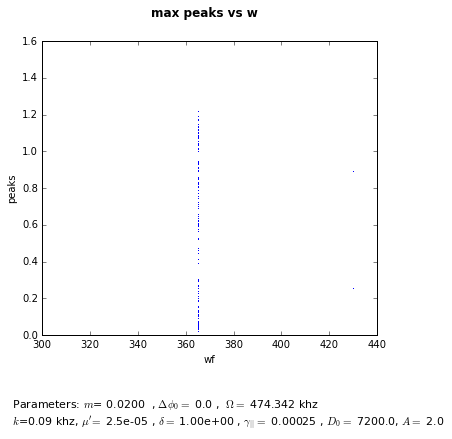

In [12]:
fig_bif=plt.figure()
fig_bif.suptitle('max peaks vs w', fontsize=12, fontweight='bold')
ax2 = fig_bif.add_subplot(111)
ax2.plot(peaks[0][1:],peaks[1][1:],',b')
ax2.set_xlabel('wf')
ax2.set_ylabel('peaks')
plt.text(-0.1,-.32, "\n Parameters: $m$= %.4f  , $\Delta \phi_0=$ %s ,  $\Omega=$ %.3f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
plt.subplots_adjust(bottom=0.22)
fig_bif.set_size_inches(6, 6)
if save==True: 
    fname='%d_%d_%d-%d.%d.%d-max_vs_w.png' % localtime()[0:6]
    fig_bif.savefig(fname, dpi = 250)# when saving, specify the DPI

In [ ]:
#fig5=plt.figure()
#ax1 = fig5.add_subplot(111)
#f1=plt.plot(time,y[:,0])
#f1=plt.plot(time,y[:,2])
#fig5.suptitle('E_x  & E_y vs tiempo', fontsize=12, fontweight='bold')
#ax1.set_xlabel('time(ms) ')
#ax1.set_ylabel('E ')
#plt.xlim(min(time), max(time))
#plt.text(-0.1,-1.04, "\n Parameters: $m= $ %s , $w_{mod}$= %.2f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
#plt.subplots_adjust(bottom=0.22)
#fig1.savefig('moduloE_fasemodulada.png')


In [ ]:
'''comparison between the solution with and without modulation'''
def comp():
    comparembfase(y,yinit,time,k,mu,Dphi0,d,g,D0,m,wf)

#comp()

Notebook style:

In [ ]:
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

a hacer:
    
    - barrido en frecuencia hacia la resonancia.
    - barrido en m, en la frecuencia de resonancia.
    - mapa de parametros usados

        periods=15
        #####
        fig0=plt.figure()
        fig0.suptitle('Temporal evolution of |E|, |P| and the Population', fontsize=12, fontweight='bold')
        ax1 = fig0.add_subplot(3, 1, 1)
        ax1.plot(time*scale,intensity)
        ax1.set_ylabel('|E| ')
        ax1.set_xlim(min(time*scale), max(time*scale))
        ax2 = fig0.add_subplot(3, 1, 2)
        ax2.set_xlim(min(time*scale), max(time*scale))
        ax2.plot(time*scale,intensity)
        ax2.set_ylabel('|P|')
        ax3 = fig0.add_subplot(3, 1, 3)
        ax3.plot(time*scale,y[:,8])
        plt.ylim(min(y[:,8]), max(y[:,8]))
        ax3.set_ylabel('Population')
        ax3.set_xlim(min(time*scale), max(time*scale))
        plt.xlabel('Time($\mu s$)')
        plt.text(-0.09,-1.05, "\n Parameters: $m= $ %s , $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
        plt.subplots_adjust(bottom=0.22)
        fig0.set_size_inches(11, 7)
        if save==True: 
            fname='%d_%d_%d-%d.%d.%d-Time_series.png' % localtime()[0:6]
            fig0.savefig(fname) 
        fig4=plt.figure()
        fig4.suptitle('Comparison between |E| and the Modulation', fontsize=12, fontweight='bold')
        ax1 = fig4.add_subplot(3, 1, 1)
        ax1.plot(time*scale,np.cos(wf*time), label='$w_{mod}$=%.2f khz' %wf_real)
        ax1.set_xlim(min(time*scale), min(time*scale)+(periods*2*pi/wf)*scale)
        ax1.set_ylabel('Modulation ')
        ax1.legend(fontsize = 'small')
        ax2 = fig4.add_subplot(3, 1, 2)
        ax2.plot(time*scale,intensity,label='First %i periods' %periods)
        ax2.set_ylabel('|E|')
        ax2.set_xlim(min(time*scale), min(time*scale)+(periods*2*pi/wf)*scale)
        ax2.legend(fontsize = 'small')
        ax3 = fig4.add_subplot(3, 1, 3)
        ax3.set_xlim(max(time*scale)-(periods*2*pi/wf)*scale, max(time*scale),emit='True')
        ax3.plot(time*scale,intensity,label='Last %i periods' %periods)
        ax3.set_ylim(intensity[len(intensity)-1]-8*(max(intensity[len(intensity)-9000:])-intensity[len(intensity)-1]),intensity[len(intensity)-1]+8*(max(intensity[len(intensity)-9000:])-intensity[len(intensity)-1]))
        ax3.set_ylabel('|E|')
        ax3.legend(fontsize = 'small')
        plt.text(-0.09,-1.06, "\n Parameters: $m= $ %s , $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax3.transAxes)   
        plt.subplots_adjust(bottom=0.22)
        fig4.set_size_inches(8, 6)
        plt.xlabel('Time ($\mu s$)')
        #ax3.relim(visible_only=True)
        #ax3.autoscale_view(tight=True, scalex=True, scaley=True)
        #ax3.yaxis.zoom(3)
        #ax3.yaxis.set_smart_bounds('True')
        if save==True: 
            fname='%d_%d_%d-%d.%d.%d-comparison periods.png' % localtime()[0:6]
            fig4.savefig(fname, dpi = 100)# when saving, specify the DPI
        fig5=plt.figure()
        fig5.suptitle('Comparison between |E| and modulation', fontsize=12, fontweight='bold')
        ax1 = fig5.add_subplot(111)
        ax1.plot(time*scale,intensity,'b', label='|E|')
        ax2=ax1.twinx()
        ax2.plot(time*scale,np.cos(wf*time),'g', alpha=0.4, label='modulation')
        ax1.set_xlabel('time($\mu s$)')
        ax1.set_ylabel('|E|')
        plt.xlim(min(time*scale), min(time*scale)+(periods*2*pi/wf)*scale)
        ax2.set_ylim(-1.5, 1.5)
        #ax2.set_ylim(-intensity[len(intensity)-1, intensity[len(intensity)-1 )
        plt.text(-0.1,-0.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.2f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
        plt.subplots_adjust(bottom=0.22)
        fig5.set_size_inches(14, 5)
        plt.legend()
        if save==True: 
            fname='%d_%d_%d-%d.%d.%d-comparison.png' % localtime()[0:6]
            fig5.savefig(fname, dpi = 100)# when saving, specify the DPI
        fig3=plt.figure()
        fig3.suptitle('|E| vs time', fontsize=12, fontweight='bold')
        ax1 = fig3.add_subplot(111)
        plt.plot(time*scale,intensity_ex,'g', alpha=0.7,  label='$|E_x|$')
        plt.plot(time*scale,intensity_ey,'r', alpha=0.6,  label='$|E_y|$')
        plt.plot(time*scale,intensity,'b', alpha=0.4, label='$|E|$')
        ax1.set_xlim(min(time*scale), min(time*scale)+(periods*2*pi/wf)*scale)
        ax1.set_xlabel('time($\mu s$)')
        ax1.set_ylabel('Electric field ')
        plt.xlim(min(time*scale), max(time*scale))
        plt.text(-0.1,-.33, "\n Parameters: $m= $ %s , $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.3f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f \n |E|(blue), |$E_x$| (Green), |$E_y$| (Red)" % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax1.transAxes)   
        plt.subplots_adjust(bottom=0.22)
        plt.legend(fontsize = 'medium')
        fig3.set_size_inches(14, 5)
        if save==True: 
            fname='%d_%d_%d-%d.%d.%d-E_intensitys.png' % localtime()[0:6]
            fig3.savefig(fname, dpi = 100)# when saving, specify the DPI
        '''Phase spaces'''
        fig8=plt.figure()
        fig8.suptitle('|P| vs population', fontsize=12, fontweight='bold')
        ax2 = fig8.add_subplot(111)
        plt.plot(y[:,8], np.sqrt(y[:,4]**2+y[:,5]**2+y[:,6]**2+y[:,7]**2))
        ax2.set_xlabel('Population')
        ax2.set_ylabel('|P|')
        plt.text(-0.1,-.32, "\n Parameters: $m= $ %s , $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.3f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
        plt.subplots_adjust(bottom=0.22)
        fig8.set_size_inches(6, 6)
        if save==True: 
            fname='%d_%d_%d-%d.%d.%d-p_vs_population.png' % localtime()[0:6]
            fig8.savefig(fname) 
        fig9=plt.figure()
        fig9.suptitle('|E| vs population', fontsize=12, fontweight='bold')
        ax2 = fig9.add_subplot(111)
        plt.plot(y[:,8], intensity)
        ax2.set_xlabel('Population')
        ax2.set_ylabel('|E|')
        plt.text(-0.1,-.32, "\n Parameters: $m= $ %s , $w_{mod}$= %.4f khz , $\Delta \phi_0=$ %s ,  $\Omega=$ %.3f khz \n $k$=%.2f khz, $\mu'=$ %s , $\delta= $ %.2e , $\gamma_{||}=$ %s , $D_0=$ %s, $A=$ %.1f " % (m,wf_real, Dphi0, w_res ,k,mu, d, g, D0, a), fontsize=11, transform=ax2.transAxes)   
        plt.subplots_adjust(bottom=0.22)
        fig9.set_size_inches(6, 6)
        if save==True: 
            fname='%d_%d_%d-%d.%d.%d-E_vs_population.png' % localtime()[0:6]
            fig9.savefig(fname, dpi = 100)# when saving, specify the DPI